In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random
from datetime import datetime
import pytz

# importo los .py
import sys
sys.path.append("auxiliares")
import config
import metricas
import lightgbm_aux
import extras

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_fe_estrellas.csv"
carpeta_base_exp = "exp/estrella/"

In [4]:
def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = metricas.error_rate(labels,preds)
    return 'ER', ret_val, False

In [5]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols_entren)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols_entren)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = metricas.error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [6]:
##############################################

In [7]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  3900 non-null   int64  
 1   periodo                     3900 non-null   int64  
 2   customer_id                 3900 non-null   int64  
 3   cero_ventas                 3900 non-null   int64  
 4   plan_precios_cuidados       3900 non-null   float64
 5   cust_request_qty            3900 non-null   float64
 6   cust_request_tn             3900 non-null   float64
 7   tn                          3900 non-null   float64
 8   periodo_fecha               3900 non-null   object 
 9   mes                         3900 non-null   int64  
 10  meses_historia_prod         3900 non-null   int64  
 11  meses_historia_cliente      3900 non-null   int64  
 12  cliente_estrella            3900 non-null   int64  
 13  prod_cust                   3900 

In [8]:
### Categoricas
df_sellout = extras.convertir_categoricas_prod_cust(df_sellout)

df_sellout = df_sellout.drop(columns=["periodo_fecha","brand"])

In [9]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[(df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())

df_validate = df_validate.sort_values(by="prod_cust",ascending=True)
print("prod_cust a validar:", len(df_validate))

Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905]
Periodos validar: [201907]
prod_cust a validar: 120


In [10]:
### Armado variables entrenamiento
cols_remover_entren = ["tn_mas_2","periodo"]

# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

cols_entren = X_train.columns.tolist()

X_train: (3180, 44)
y_train: (3180,)

X_validate: (120, 44)
y_validate: (120,)


In [11]:
### Optimizacion Bayesiana
GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

[I 2023-12-12 23:55:21,292] A new study created in memory with name: no-name-c8864525-58a0-4b14-9939-48a6162d5d9c
[I 2023-12-12 23:55:21,356] Trial 0 finished with value: 102.6 and parameters: {'lambda_l1': 652.1777412859394, 'lambda_l2': 782.7929865424162, 'learning_rate': 0.08030461455051097, 'num_leaves': 298, 'feature_fraction': 0.6145439214243382, 'min_data_in_leaf': 3008}. Best is trial 0 with value: 102.6.


**************** regression ****************
Training until validation scores don't improve for 112 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 472 rounds
[100]	valid_0's ER: 90.22
[200]	valid_0's ER: 82
[300]	valid_0's ER: 78
[400]	valid_0's ER: 74.14
[500]	valid_0's ER: 71.39
[600]	valid_0's ER: 68.77
[700]	valid_0's ER: 66.58
[800]	valid_0's ER: 64.81
[900]	valid_0's ER: 63.43
[1000]	valid_0's ER: 62.58
[1100]	valid_0's ER: 61.79
[1200]	valid_0's ER: 61.33
[1300]	valid_0's ER: 61.08
[1400]	valid_0's ER: 60.83
[1500]	valid_0's ER: 60.65
[1600]	valid_0's ER: 60.5
[1700]	valid_0's ER: 60.29
[1800]	valid_0's ER: 59.99
[1900]	valid_0's ER: 59.86
[2000]	valid_0's ER: 59.79
[2100]	valid_0's ER: 59.71
[2200]	valid_0's ER: 59.55
[2300]	valid_0's ER: 59.39
[2400]	valid_0's ER: 59.3
[2500]	valid_0's ER: 59.14
[2600]	valid_0's ER: 5

[I 2023-12-12 23:55:24,889] Trial 1 finished with value: 55.22 and parameters: {'lambda_l1': 729.0860537685355, 'lambda_l2': 73.57945775576724, 'learning_rate': 0.011845971893819368, 'num_leaves': 15, 'feature_fraction': 0.23645640508756421, 'min_data_in_leaf': 847}. Best is trial 1 with value: 55.22.
[I 2023-12-12 23:55:24,966] Trial 2 finished with value: 102.6 and parameters: {'lambda_l1': 821.1774961312841, 'lambda_l2': 161.42581047786885, 'learning_rate': 0.1651668548560594, 'num_leaves': 747, 'feature_fraction': 0.23445611461888768, 'min_data_in_leaf': 1618}. Best is trial 1 with value: 55.22.
[I 2023-12-12 23:55:25,012] Trial 3 finished with value: 102.6 and parameters: {'lambda_l1': 172.66865620741257, 'lambda_l2': 537.3561182947071, 'learning_rate': 0.2202049088929976, 'num_leaves': 703, 'feature_fraction': 0.33462432205876613, 'min_data_in_leaf': 5721}. Best is trial 1 with value: 55.22.
[I 2023-12-12 23:55:25,058] Trial 4 finished with value: 102.6 and parameters: {'lambda_l

**************** regression ****************
Training until validation scores don't improve for 80 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 72 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 88 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 435 rounds


[I 2023-12-12 23:55:25,172] Trial 5 finished with value: 102.6 and parameters: {'lambda_l1': 662.9648825118405, 'lambda_l2': 730.8145789181904, 'learning_rate': 0.012965638432345234, 'num_leaves': 237, 'feature_fraction': 0.3000584750378996, 'min_data_in_leaf': 5153}. Best is trial 1 with value: 55.22.
[I 2023-12-12 23:55:25,214] Trial 6 finished with value: 102.6 and parameters: {'lambda_l1': 674.2364910022013, 'lambda_l2': 751.0539209592173, 'learning_rate': 0.13072408237088734, 'num_leaves': 365, 'feature_fraction': 0.6531395823072421, 'min_data_in_leaf': 4154}. Best is trial 1 with value: 55.22.
[I 2023-12-12 23:55:25,256] Trial 7 finished with value: 102.6 and parameters: {'lambda_l1': 497.1154693410753, 'lambda_l2': 49.41861265119496, 'learning_rate': 0.13027306477294903, 'num_leaves': 645, 'feature_fraction': 0.954531184969156, 'min_data_in_leaf': 3435}. Best is trial 1 with value: 55.22.


[100]	valid_0's ER: 166.18
[200]	valid_0's ER: 166.18
[300]	valid_0's ER: 166.18
[400]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 88 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 88 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 109 rounds
[100]	valid_0's ER: 84.56
[200]	valid_0's ER: 81.54
[300]	valid_0's ER: 81.08
[400]	valid_0's ER: 80.71
[500]	valid_0's ER: 80.49
[600]	valid_0's ER: 80.49
Early stopping, best iteration is:
[507]	valid_0's ER: 80.44
Evaluated only: ER


[I 2023-12-12 23:55:25,529] Trial 8 finished with value: 80.44 and parameters: {'lambda_l1': 227.87809048888997, 'lambda_l2': 957.6494509959567, 'learning_rate': 0.08334849305754852, 'num_leaves': 486, 'feature_fraction': 0.5229417738197588, 'min_data_in_leaf': 1178}. Best is trial 1 with value: 55.22.


**************** regression ****************
Training until validation scores don't improve for 86 rounds
[100]	valid_0's ER: 56.22
[200]	valid_0's ER: 55.04


[I 2023-12-12 23:55:25,751] Trial 9 finished with value: 54.92 and parameters: {'lambda_l1': 533.3398855363862, 'lambda_l2': 620.339553086254, 'learning_rate': 0.13544474514028818, 'num_leaves': 361, 'feature_fraction': 0.9387753680977968, 'min_data_in_leaf': 413}. Best is trial 9 with value: 54.92.
[I 2023-12-12 23:55:25,835] Trial 10 finished with value: 102.6 and parameters: {'lambda_l1': 960.3923491606442, 'lambda_l2': 485.44038327472816, 'learning_rate': 0.2990264647018198, 'num_leaves': 986, 'feature_fraction': 0.9784430583332826, 'min_data_in_leaf': 7953}. Best is trial 9 with value: 54.92.


Early stopping, best iteration is:
[192]	valid_0's ER: 54.92
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 66 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 362 rounds
[100]	valid_0's ER: 63.17
[200]	valid_0's ER: 55.6
[300]	valid_0's ER: 53.07
[400]	valid_0's ER: 51.97
[500]	valid_0's ER: 51.96
[600]	valid_0's ER: 52.23
[700]	valid_0's ER: 52.09


[I 2023-12-12 23:55:26,950] Trial 11 finished with value: 51.86 and parameters: {'lambda_l1': 456.55117240025487, 'lambda_l2': 50.4070116521781, 'learning_rate': 0.01598504010832047, 'num_leaves': 14, 'feature_fraction': 0.8002175646911395, 'min_data_in_leaf': 119}. Best is trial 11 with value: 51.86.


[800]	valid_0's ER: 52.12
Early stopping, best iteration is:
[474]	valid_0's ER: 51.86
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 129 rounds
[100]	valid_0's ER: 53.67
[200]	valid_0's ER: 52.89
[300]	valid_0's ER: 52.42
[400]	valid_0's ER: 52.39
[500]	valid_0's ER: 52.36


[I 2023-12-12 23:55:27,704] Trial 12 finished with value: 52.21 and parameters: {'lambda_l1': 452.79273327146865, 'lambda_l2': 244.143033144737, 'learning_rate': 0.06307606414585824, 'num_leaves': 20, 'feature_fraction': 0.8344603124714988, 'min_data_in_leaf': 142}. Best is trial 11 with value: 51.86.
[I 2023-12-12 23:55:27,782] Trial 13 finished with value: 102.6 and parameters: {'lambda_l1': 340.68847585468427, 'lambda_l2': 239.82011900733465, 'learning_rate': 0.05011328495737374, 'num_leaves': 19, 'feature_fraction': 0.7994536424444305, 'min_data_in_leaf': 2192}. Best is trial 11 with value: 51.86.


Early stopping, best iteration is:
[448]	valid_0's ER: 52.21
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 149 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 152 rounds
[100]	valid_0's ER: 52.32
[200]	valid_0's ER: 53.91


[I 2023-12-12 23:55:30,524] Trial 14 finished with value: 51.85 and parameters: {'lambda_l1': 3.2031238627124594, 'lambda_l2': 27.040926251258895, 'learning_rate': 0.04865604158599028, 'num_leaves': 129, 'feature_fraction': 0.799165448120327, 'min_data_in_leaf': 0}. Best is trial 14 with value: 51.85.
[I 2023-12-12 23:55:30,608] Trial 15 finished with value: 102.6 and parameters: {'lambda_l1': 154.60750680700045, 'lambda_l2': 25.390928738688856, 'learning_rate': 0.041885303108186174, 'num_leaves': 155, 'feature_fraction': 0.7518147985974737, 'min_data_in_leaf': 2245}. Best is trial 14 with value: 51.85.


Early stopping, best iteration is:
[84]	valid_0's ER: 51.85
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 169 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 106 rounds


[I 2023-12-12 23:55:31,158] Trial 16 finished with value: 52.18 and parameters: {'lambda_l1': 44.52386229484562, 'lambda_l2': 10.497211012634615, 'learning_rate': 0.08808136006921505, 'num_leaves': 160, 'feature_fraction': 0.7114565785933085, 'min_data_in_leaf': 31}. Best is trial 14 with value: 51.85.


[100]	valid_0's ER: 54.49
Early stopping, best iteration is:
[40]	valid_0's ER: 52.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:55:31,291] Trial 17 finished with value: 102.6 and parameters: {'lambda_l1': 38.911891225127704, 'lambda_l2': 349.7652778334554, 'learning_rate': 0.012277307798720327, 'num_leaves': 481, 'feature_fraction': 0.8699339420389255, 'min_data_in_leaf': 1699}. Best is trial 14 with value: 51.85.
[I 2023-12-12 23:55:31,376] Trial 18 finished with value: 102.6 and parameters: {'lambda_l1': 296.58505992316066, 'lambda_l2': 134.64816895488937, 'learning_rate': 0.04157300281848725, 'num_leaves': 126, 'feature_fraction': 0.8662523724730382, 'min_data_in_leaf': 3111}. Best is trial 14 with value: 51.85.


Training until validation scores don't improve for 457 rounds
[100]	valid_0's ER: 166.18
[200]	valid_0's ER: 166.18
[300]	valid_0's ER: 166.18
[400]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 170 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:55:31,454] Trial 19 finished with value: 102.6 and parameters: {'lambda_l1': 398.79547190814105, 'lambda_l2': 145.6139397110953, 'learning_rate': 0.09812358437487426, 'num_leaves': 270, 'feature_fraction': 0.7327655872745406, 'min_data_in_leaf': 7726}. Best is trial 14 with value: 51.85.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 204 rounds
[100]	valid_0's ER: 87.45
[200]	valid_0's ER: 83.8
[300]	valid_0's ER: 81.73
[400]	valid_0's ER: 81.05
[500]	valid_0's ER: 80.99
[600]	valid_0's ER: 80.96
[700]	valid_0's ER: 80.62
[800]	valid_0's ER: 80.41
[900]	valid_0's ER: 80.31
[1000]	valid_0's ER: 80.1
[1100]	valid_0's ER: 79.91
[1200]	valid_0's ER: 79.77
[1300]	valid_0's ER: 79.48
[1400]	valid_0's ER: 79.3


[I 2023-12-12 23:55:32,351] Trial 20 finished with value: 79.25 and parameters: {'lambda_l1': 12.069233701625592, 'lambda_l2': 340.5931567791116, 'learning_rate': 0.03227837547938858, 'num_leaves': 904, 'feature_fraction': 0.5316247081353042, 'min_data_in_leaf': 971}. Best is trial 14 with value: 51.85.


[1500]	valid_0's ER: 79.4
Early stopping, best iteration is:
[1335]	valid_0's ER: 79.25
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 124 rounds
[100]	valid_0's ER: 52.4


[I 2023-12-12 23:55:32,873] Trial 21 finished with value: 51.72 and parameters: {'lambda_l1': 104.92794974300244, 'lambda_l2': 15.85638304529403, 'learning_rate': 0.0674920551764681, 'num_leaves': 132, 'feature_fraction': 0.7138561906989741, 'min_data_in_leaf': 52}. Best is trial 21 with value: 51.72.


[200]	valid_0's ER: 54.11
Early stopping, best iteration is:
[78]	valid_0's ER: 51.72
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 131 rounds
[100]	valid_0's ER: 58.63
[200]	valid_0's ER: 55.96
[300]	valid_0's ER: 54.55


[I 2023-12-12 23:55:33,170] Trial 22 finished with value: 53.73 and parameters: {'lambda_l1': 146.5656066005813, 'lambda_l2': 20.165179547661467, 'learning_rate': 0.06150402714046713, 'num_leaves': 101, 'feature_fraction': 0.7755403437298592, 'min_data_in_leaf': 852}. Best is trial 21 with value: 51.72.


[400]	valid_0's ER: 53.8
[500]	valid_0's ER: 53.87
Early stopping, best iteration is:
[413]	valid_0's ER: 53.73
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 200 rounds
[100]	valid_0's ER: 56.19
[200]	valid_0's ER: 52.27
[300]	valid_0's ER: 51.69
[400]	valid_0's ER: 51.68


[I 2023-12-12 23:55:34,705] Trial 23 finished with value: 51.52 and parameters: {'lambda_l1': 98.75779390606857, 'lambda_l2': 92.45670247138425, 'learning_rate': 0.033189561581947524, 'num_leaves': 387, 'feature_fraction': 0.667983203456592, 'min_data_in_leaf': 37}. Best is trial 23 with value: 51.52.


[500]	valid_0's ER: 51.95
Early stopping, best iteration is:
[344]	valid_0's ER: 51.52
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:55:34,790] Trial 24 finished with value: 102.6 and parameters: {'lambda_l1': 93.40924992829058, 'lambda_l2': 114.60293302511684, 'learning_rate': 0.061463054952729856, 'num_leaves': 399, 'feature_fraction': 0.6779605386388237, 'min_data_in_leaf': 1813}. Best is trial 23 with value: 51.52.


Training until validation scores don't improve for 131 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 192 rounds
[100]	valid_0's ER: 61.61
[200]	valid_0's ER: 57.85
[300]	valid_0's ER: 56.41
[400]	valid_0's ER: 55.17
[500]	valid_0's ER: 54.64
[600]	valid_0's ER: 54.1
[700]	valid_0's ER: 53.91


[I 2023-12-12 23:55:35,377] Trial 25 finished with value: 53.7 and parameters: {'lambda_l1': 239.62938964043857, 'lambda_l2': 1.4798063358936453, 'learning_rate': 0.035090399065049266, 'num_leaves': 559, 'feature_fraction': 0.6555853014611582, 'min_data_in_leaf': 818}. Best is trial 23 with value: 51.52.


[800]	valid_0's ER: 53.78
[900]	valid_0's ER: 53.74
[1000]	valid_0's ER: 53.74
[1100]	valid_0's ER: 53.78
Early stopping, best iteration is:
[940]	valid_0's ER: 53.7
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:55:35,453] Trial 26 finished with value: 102.6 and parameters: {'lambda_l1': 70.46375124117331, 'lambda_l2': 191.02405488657917, 'learning_rate': 0.1083852455134322, 'num_leaves': 227, 'feature_fraction': 0.7095297930815887, 'min_data_in_leaf': 2329}. Best is trial 23 with value: 51.52.


Training until validation scores don't improve for 96 rounds
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 120 rounds
[100]	valid_0's ER: 82.99
[200]	valid_0's ER: 80.96
[300]	valid_0's ER: 80.43


[I 2023-12-12 23:55:35,807] Trial 27 finished with value: 79.96 and parameters: {'lambda_l1': 117.19347964234808, 'lambda_l2': 99.33612570790685, 'learning_rate': 0.07097595964781182, 'num_leaves': 425, 'feature_fraction': 0.5860801164263021, 'min_data_in_leaf': 1308}. Best is trial 23 with value: 51.52.


[400]	valid_0's ER: 80.36
[500]	valid_0's ER: 80.16
[600]	valid_0's ER: 80.01
[700]	valid_0's ER: 79.96
[800]	valid_0's ER: 80.02
Early stopping, best iteration is:
[699]	valid_0's ER: 79.96
Evaluated only: ER
**************** regression ****************


[I 2023-12-12 23:55:35,892] Trial 28 finished with value: 102.6 and parameters: {'lambda_l1': 7.651511111633226, 'lambda_l2': 190.94045927376794, 'learning_rate': 0.050204589071916814, 'num_leaves': 315, 'feature_fraction': 0.9062170187340947, 'min_data_in_leaf': 4430}. Best is trial 23 with value: 51.52.
[I 2023-12-12 23:55:35,974] Trial 29 finished with value: 102.6 and parameters: {'lambda_l1': 219.82120753022582, 'lambda_l2': 91.35091302025606, 'learning_rate': 0.07749452802742418, 'num_leaves': 582, 'feature_fraction': 0.6156720752387321, 'min_data_in_leaf': 2776}. Best is trial 23 with value: 51.52.


Training until validation scores don't improve for 149 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
**************** regression ****************
Training until validation scores don't improve for 114 rounds
[100]	valid_0's ER: 166.18
Early stopping, best iteration is:
[1]	valid_0's ER: 166.18
Evaluated only: ER
# Experimentos: 30
Mejor experimento: {'lambda_l1': 98.75779390606857, 'lambda_l2': 92.45670247138425, 'learning_rate': 0.033189561581947524, 'num_leaves': 387, 'feature_fraction': 0.667983203456592, 'min_data_in_leaf': 37}


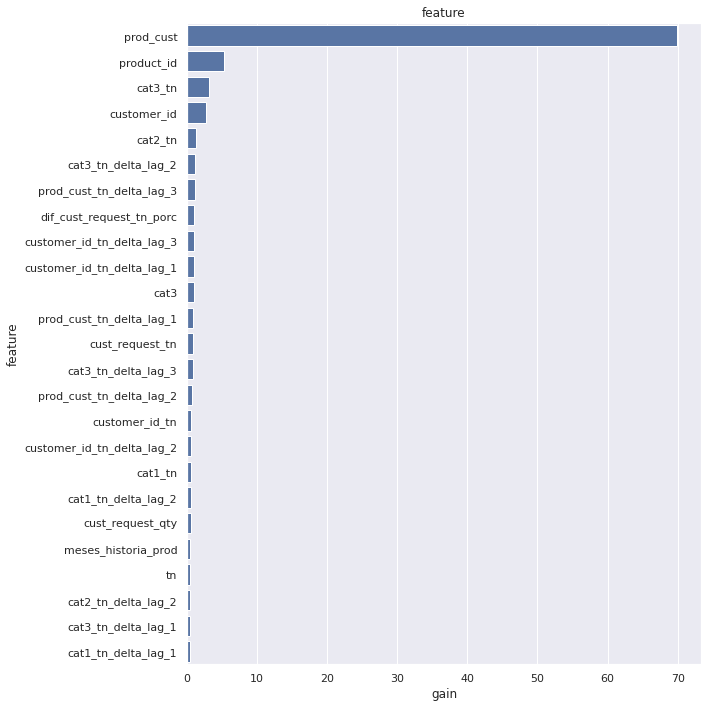

In [12]:
# Feature Importance
best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
feature_importance = lightgbm_aux.plot_lgb_importances(best_model, num=30, plot=True)

In [13]:
#Si se usa holdout, se generan variables para luego evaluar modelos
if(config.USAR_HOLDOUT_PARAM):
    # Dataframes
    df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
    df_holdout = df_sellout[(df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM)]
    
    df_holdout = df_holdout.sort_values(by="prod_cust",ascending=True)
    print("prod_cust a testear:", len(df_holdout))

    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    # Variables entrenamiento
    X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
    X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols_entren)

prod_cust a testear: 120
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812 201901 201902 201903 201904 201905 201906
 201907]
Periodos holdout: [201910]

X_train_all: (3420, 44)
y_train_all: (3420,)

X_holdout: (120, 44)
y_holdout: (120,)


In [14]:
current_datetime = datetime.now().astimezone(pytz.timezone('America/Argentina/Buenos_Aires'))
exp_numero = current_datetime.strftime("%Y%m%d %H%M%S").replace(" ", "_")
exp_numero

'20231212_205536'

In [15]:
# Guardo resultados
carpeta_exp = carpeta_base_exp + exp_numero + "/"
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
# Feature Importance
feature_importance.to_csv(carpeta_exp + "feature_importance.csv",index=False)

# Parametros
parametros_nombres = ["PERIODO_INICIO_PARAM","TRAIN_PERIODO_LIMITE_PARAM","VALIDATE_PERIODO_PARAM","USAR_HOLDOUT_PARAM",
                      "TRAIN_ALL_PERIODO_LIMITE_PARAM","HOLDOUT_PERIODO_PARAM",
                      "MODELO_FINAL_PERIODO_LIMITE_PARAM","FUTURE_PERIODO_PARAM",
                      "ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO","ARCH_PRODUCTOS_PREDICCION_FUTURE",
                      "NUM_LAGS_PARAM","FAMILIA_FEATURES_TEMP_PARAM",
                      "CANT_ITERACIONES_OPT_BAY_PARAM","CANT_SEMILLAS"]

parametros_valores = [config.PERIODO_INICIO_PARAM,config.TRAIN_PERIODO_LIMITE_PARAM,config.VALIDATE_PERIODO_PARAM,
                      config.USAR_HOLDOUT_PARAM,config.TRAIN_ALL_PERIODO_LIMITE_PARAM,config.HOLDOUT_PERIODO_PARAM,
                      config.MODELO_FINAL_PERIODO_LIMITE_PARAM,config.FUTURE_PERIODO_PARAM,
                      config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO,config.ARCH_PRODUCTOS_PREDICCION_FUTURE,
                      config.NUM_LAGS_PARAM,config.FAMILIA_FEATURES_TEMP_PARAM,
                      config.CANT_ITERACIONES_OPT_BAY_PARAM, config.CANT_SEMILLAS]

parametros = pd.DataFrame(data={"nombre":parametros_nombres,"valor":parametros_valores})
parametros.to_csv(carpeta_exp + "parametros.csv",index=False)

# Optimizacion Bayesiana
df_opt_bay = pd.DataFrame(data={"lgb_params":GLOBAL_PARAMS_ITER,"best_iteration":GLOBAL_BEST_IT_ITER,
                                "error_rate_validate":GLOBAL_ER_VALIDATE_ITER})

# Ordeno de menor a mayor
df_opt_bay = df_opt_bay.sort_values(by="error_rate_validate",ascending=True)
df_opt_bay["index"] = range(0,len(GLOBAL_PARAMS_ITER))

# Holdout
if(config.USAR_HOLDOUT_PARAM):
    er_holdout_iter = [None] * len(df_opt_bay)
    er_holdout_semillerio_iter = [None] * len(df_opt_bay)
    
    for i in range(config.OFFSET_EVAL_HOLDOUT,config.CANT_EVAL_HOLDOUT):
        print("Iteración:",i)

        #Modelo Train All (Sin Semillerio)
        model_train_all = lgb.train(df_opt_bay.iloc[i].lgb_params, lgbtrain_all, num_boost_round=df_opt_bay.iloc[i].best_iteration)
        y_pred_holdout = model_train_all.predict(X_holdout)
        er_holdout = metricas.error_rate(y_holdout,y_pred_holdout)
        er_holdout_iter[i]=er_holdout
        
        #Semillerio
        y_pred_holdout_semillerio = lightgbm_aux.semillerio(lgbtrain_all, df_opt_bay.iloc[i].lgb_params, df_opt_bay.iloc[i].best_iteration, X_holdout,config.CANT_SEMILLAS)
        er_holdout_semillerio_iter[i]= metricas.error_rate(y_holdout,y_pred_holdout_semillerio)
        
    df_opt_bay["error_rate_holdout"]=er_holdout_iter    
    df_opt_bay["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    

df_opt_bay.to_excel(carpeta_exp +  "opt_bay.xlsx",index=False)

Iteración: 0
Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4


In [16]:
print("FINALIZADO")

FINALIZADO
